# **Sentiment Analysis**
Based on IMDB movie reviews

**importing necessary libraries**

In [18]:
import numpy as np # Used for numerical operations and array handling
from keras.datasets import imdb # Used to load the IMDb movie review dataset
from keras.models import Sequential # Used to create a sequential model
from keras.layers import Embedding, LSTM, Dense, Dropout # Used to define different layers in the model
from keras.preprocessing import sequence # Used for sequence preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences # Used for padding sequences
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight # Used to calculate class weights for handling class imbalance

**loading and preprocessing the data**

In [19]:
#Load the IMDb movie review dataset
"""
loads the IMDb movie review dataset using the imdb.load_data() function from the Keras library. 
It splits the dataset into training and testing sets and assigns them to (X_train, y_train) and (X_test, y_test) variables, respectively. 
The parameter num_words=max_words limits the vocabulary size by keeping only the most frequent max_words words in the dataset.
"""
max_words = 20000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=max_words)

#Preprocess the dataset
"""
It uses the pad_sequences() function from Keras to pad or truncate the sequences of movie reviews to have a fixed length of max_sequence_length. 
This ensures that all input sequences have the same length, which is necessary for training a neural network model. 
The padded/truncated sequences are then assigned back to X_train and X_test variables.
"""
max_sequence_length = 200
X_train = pad_sequences(X_train, maxlen=max_sequence_length)
X_test = pad_sequences(X_test, maxlen=max_sequence_length)

#Split the data into training, validation, and test sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [20]:
X_train

array([[  24,   15,  821, ...,   10,  470,  158],
       [   7,    2,   37, ...,    6, 2761,  632],
       [ 186,    8, 7147, ..., 1689,  798,   12],
       ...,
       [ 683,   12,   15, ...,    7,   14,  509],
       [   0,    0,    0, ...,   25,  170, 2241],
       [   0,    0,    0, ...,   25,  194,  757]], dtype=int32)

**Handling class imbalance**

To address class imbalance issue, class weights are used to assign different weights to each class during training. Higher weights are assigned to underrepresented classes, giving them more importance and ensuring that the model pays more attention to them during training. The weights are inversely proportional to the class frequencies, with higher weights assigned to less frequent classes.

In [21]:
#Calculate class weights to handle class imbalance
unique_classes, class_counts = np.unique(y_train, return_counts=True)
total_samples = len(y_train)
class_weights = {cls: total_samples / (len(unique_classes) * count) for cls, count in zip(unique_classes, class_counts)}

**Build and Train Model**
<br>
The following builds a sentiment analysis model using a sequential architecture with an embedding layer, LSTM layer, and dense layer. It then trains the model on the IMDb movie review dataset. The embedding layer converts the input sequences into fixed-length dense vectors. The LSTM layer processes the sequential information in the vectors. The dense layer produces a binary output indicating the sentiment of the input text. After which the model is trained using the training data, with class weights assigned to handle class imbalance. Finally the model's performance is evaluated on the validation set.

In [22]:
#Build the sentiment analysis model
embedding_size = 128
model = Sequential()
model.add(Embedding(max_words, embedding_size, input_length=max_sequence_length))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#Train the model
batch_size = 64
epochs = 5
# Store the history of training for later visualization
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, epochs=epochs, class_weight=class_weights)

#Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch 1/5
313/313 [==============================] - 343s 1s/step - loss: 0.4413 - accuracy: 0.7915 - val_loss: 0.3211 - val_accuracy: 0.8708
Epoch 2/5
313/313 [==============================] - 324s 1s/step - loss: 0.2352 - accuracy: 0.9093 - val_loss: 0.3427 - val_accuracy: 0.8748
Epoch 3/5
313/313 [==============================] - 334s 1s/step - loss: 0.1460 - accuracy: 0.9473 - val_loss: 0.3541 - val_accuracy: 0.8540
Epoch 4/5
313/313 [==============================] - 338s 1s/step - loss: 0.0928 - accuracy: 0.9676 - val_loss: 0.4067 - val_accuracy: 0.8620
Epoch 5/5
313/313 [==============================] - 336s 1s/step - loss: 0.0747 - accuracy: 0.9747 - val_loss: 0.5362 - val_accuracy: 0.8626
Loss: 0.5873, Accuracy: 0.8482


**Plot the loss-accuracy graph**

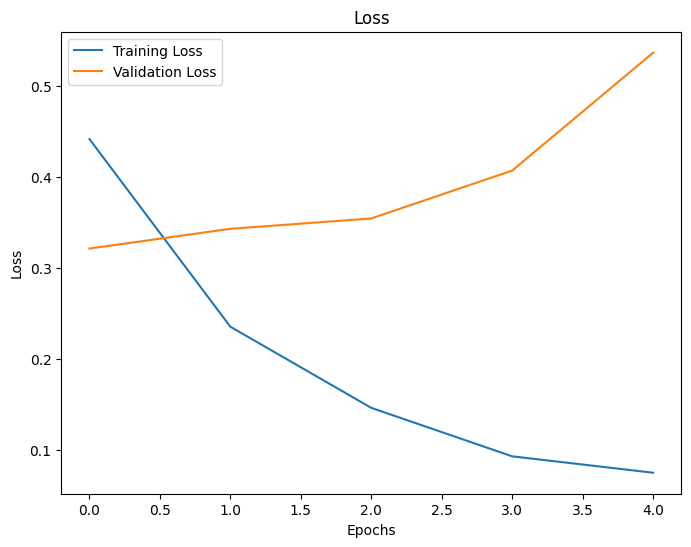

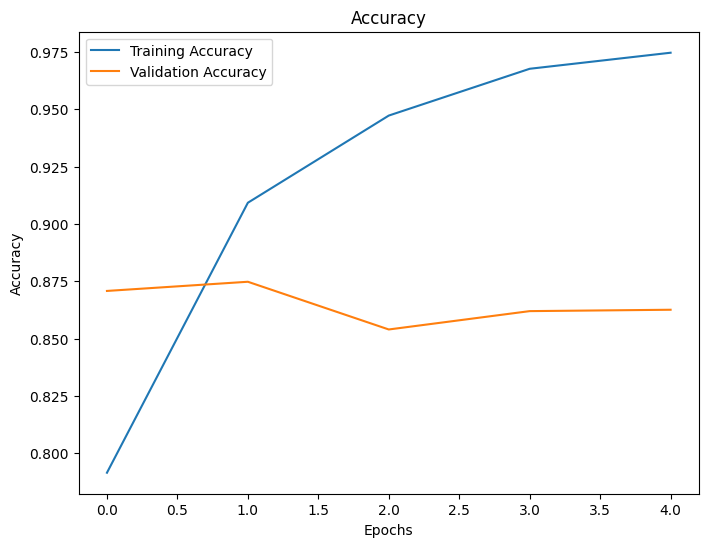

In [23]:
import matplotlib.pyplot as plt


# Plot the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


**Test the model on different reviews**

In [24]:
# Make predictions on test reviews
# Define the new texts
new_texts = [
    "This movie was a wonderful movie. I only have positive comments about it!",
    "The acting was terrible which made the movie bad and a waste of money and time.",
    "I'm not sure how I feel about this movie. It had some good moments, but overall, it was disappointing."]

# Get the word index dictionary from the IMDb dataset
new_sequences = imdb.get_word_index()
# Initialize a list to store the encoded sequences of the new texts
new_padded_sequences = []

# Iterate over each new text
for text in new_texts:
    # Initialize a list to store the encoded version of the text
    new_sequence = []
    # Convert the text to lowercase and split into individual words
    for word in text.lower().split():
        # Check if the word exists in the word index dictionary
        # and if its index is within the specified vocabulary size (max_words)
        if word in new_sequences and new_sequences[word] < max_words:
            # Append the index of the word to the new sequence
            new_sequence.append(new_sequences[word])
     # Add the new sequence to the list of encoded sequences
    new_padded_sequences.append(new_sequence)

# Pad the encoded sequences to a fixed length
new_padded_sequences = pad_sequences(new_padded_sequences, maxlen=max_sequence_length)
# Make predictions on the new padded sequences using the trained model
predictions = model.predict(new_padded_sequences)
# Assign sentiments based on prediction threshold and create a list of sentiments
sentiments = ['positive' if pred >= 0.5 else 'negative' for pred in predictions]

# Iterate over the original texts and predicted sentiments, and print them
for text, sentiment in zip(new_texts, sentiments):
    print(f'Text: {text}\nSentiment: {sentiment}\n')


1/1 [==============================] - 0s 311ms/step
Text: This movie was a wonderful movie. I only have positive comments about it!
Sentiment: positive

Text: The acting was terrible which made the movie bad and a waste of money and time.
Sentiment: positive

Text: I'm not sure how I feel about this movie. It had some good moments, but overall, it was disappointing.
Sentiment: negative



**Save the model**

In [25]:
model.save('sentiment_analysis_model1.h5')


**Reload the model and make prediction on a new review**

In [26]:
import numpy as np
from keras.models import load_model
from keras.preprocessing import sequence
from keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [27]:
# Load the previously saved model
model = load_model('sentiment_analysis_model1.h5')
# Load the IMDb word index for tokenization
word_index = imdb.get_word_index()

In [28]:
# Sample review for testing
review = "This movie is fantastic! I highly recommend it."
# Preprocess the review
max_sequence_length = 200
review_tokens = review.lower().split()
review_indices = [word_index[word] + 3 if word in word_index and word_index[word] < 10000 else 2 for word in review_tokens]
review_padded = pad_sequences([review_indices], maxlen=max_sequence_length)

In [29]:
# Make predictions
prediction = model.predict(review_padded)[0][0]
sentiment = "positive" if prediction >= 0.5 else "negative"
# Print the result
print(f"Review: {review}")
print(f"Sentiment: {sentiment}")
print(f"Confidence: {prediction:.4f}")


1/1 [==============================] - 0s 303ms/step
Review: This movie is fantastic! I highly recommend it.
Sentiment: positive
Confidence: 0.9017
